In [26]:
import numpy as np
import skrf as rf
import matplotlib.pyplot as plt
from skrf.constants import K_BOLTZMANN
import pandas as pd
from scipy.interpolate import interp1d
from skrf.noisyComponents import Attenuator, Circulator
import os
import glob

In [27]:
# checking if the data is in the right directory
data_dir = '../../../../data/'
glob.glob(dara_dir + '/*.csv')

['../../../../data/LNF-LNC16_28WB_gain_datasheet.csv',
 '../../../../data/LNF-LNC16_28WB_noisetemperature_datasheet.csv',
 '../../../../data/ZX60_83LN_NF.csv']

In [33]:
###################################################################################################################
# Function to return linear NF from covariance matrix
###################################################################################################################
def return_nf(port, noise_ntwk):
    #Currently must be a two port device

    I = np.identity(np.shape(noise_ntwk.s)[1])
    I[port-1,port-1] = np.zeros_like(noise_ntwk.cs[0,port-1,port-1],dtype=float)
    AS = np.matmul(I, np.conjugate(noise_ntwk.s.swapaxes(1, 2)))
    SAS = np.matmul(noise_ntwk.s, AS)
    F2 = 1 +  np.real(noise_ntwk.cs[:,port-1,port-1]) / (K_BOLTZMANN*290*SAS[:,port-1,port-1])

    return F2

######################################################################################################################
## Function to make passive devices into noisy networks
######################################################################################################################
def read_in_noisy_netowrk(file_path,file_name,freq_interp,Tphys):
    file_loc = os.path.join(file_path,file_name)
    file_net = rf.Network(file_loc)
    file_net_interp = file_net.interpolate(freq_interp, kind='cubic')
    file_net_interp_noisy = rf.NoisyNetwork(file_net_interp)
    file_net_interp_noisy.noise_source(source='passive',T0 = Tphys)
    
    return file_net_interp_noisy

####################################################################################################################
## functions to simulate ZX60-83LN-S+ 
####################################################################################################################

def gen_amp_S_NF_func(ZX60_83LN_NF_loc):
    noise_figure_data2 = pd.read_csv(ZX60_83LN_NF_loc  , header = None)
    noise_figure_data2[3] = 10**(noise_figure_data2[1]/10)
    NF_Func2 = interp1d(noise_figure_data2[0],noise_figure_data2[3],fill_value=1000)

    return NF_Func2

def return_amp_params(Amp_path,NF_path,freq_any,sat_check = False, vendor = True, Temp = 290):
   
    Tphys = Temp

    amp_sparam = rf.Network(Amp_path)
    amp_sparam = amp_sparam.interpolate(freq_any, kind='cubic')
    amp_sparam = rf.NoisyNetwork(amp_sparam)
    amp_sparam.noise_source(source='passive',T0 = Tphys) # why is this passive?
    
    try:
        NF_func = gen_amp_S_NF_func(NF_path)
        #nfig = NF_func(freq.f/1e9)
        nfig=NF_func(freq_any.f/1e9)
        print((nfig), 'bing',np.shape(nfig))
    except:
        print('error')

    Tnoise = rf.NetworkNoiseCov.Tnoise(freq_any.f,Tphys) # THis is just the physical temperature

    
    I = np.identity(np.shape(amp_sparam.s)[1]) 
    AS = np.matmul(I, np.conjugate(amp_sparam.s.swapaxes(1, 2)))
    SAS = np.matmul(amp_sparam.s, AS)

    amp_sparam.cs[:,0,0] = (nfig-1) * K_BOLTZMANN * 290 * SAS[:,0,0]

    I = np.identity(np.shape(amp_sparam.s)[1])
    AS = np.matmul(I, np.conjugate(amp_sparam.s.swapaxes(1, 2)))
    SAS = np.matmul(amp_sparam.s, AS)

    amp_sparam.cs[:,1,1] = (nfig-1) * K_BOLTZMANN * 290* SAS[:,1,1]

    amp_sparam.cs[:,0,1] = np.zeros_like(amp_sparam.cs[:,1,1])
    amp_sparam.cs[:,1,0] = amp_sparam.cs[:,0,1]  
    
    return amp_sparam

In [34]:
# make a frequency array between 400MHz and 8GHz with 1001 points
freq_meg = rf.frequency.Frequency(start=20, stop=27, npoints=2001, unit='ghz', sweep_type='lin')
freq1 = rf.frequency.Frequency(start=0.5, stop=7, npoints=2001, unit='ghz', sweep_type='lin')

NF_func = gen_amp_S_NF_func(data_dir+'LNF-LNC16_28WB_noisetemperature_datasheet.csv')

print(freq_meg)
print(NF_func(freq_meg.f/1e9))

20.0-27.0 GHz, 2001 pts
[ 4.71022634  4.71035254  4.71047873 ... 11.87285372 11.85599946
 11.8391452 ]


In [35]:
attn_path = data_dir+'KAT-20+_Plus25DegC_Unit1.s2p'
print(os.path.isfile(attn_path))

# The following lines create an error for me.
#attn=rf.Network(attn_path,f_unit='Hz')

attn_290k=read_in_noisy_netowrk(data_dir,'KAT-20+_Plus25DegC_Unit1.s2p',freq_meg,290)
attn_580k=read_in_noisy_netowrk(data_dir,'KAT-20+_Plus25DegC_Unit1.s2p',freq_meg,290*2)
attn_29k=read_in_noisy_netowrk(data_dir,'KAT-20+_Plus25DegC_Unit1.s2p',freq_meg,29)

# Create nosiy amplifiers from S-parameters and noise figure data 
amp_path_meg=data_dir+'LNF-LNC16_28WB_sn149Z.s2p'
amplifier_NF_path_meg=data_dir+'LNF-LNC16_28WB_noisetemperature_datasheet.csv'
# check if these files exist:
print(os.path.isfile(amp_path_meg))
print(os.path.isfile(amplifier_NF_path_meg))

amp_meg=return_amp_params(amp_path_meg,amplifier_NF_path_meg,freq_meg,sat_check = False, vendor = True, Temp = 29)

amplifier_path=data_dir+'ZX60-83LN-S+_AP160503_060216_RFPARAM_Unit1.s2p'
amplifier_NF_path=data_dir+'ZX60_83LN_NF.csv'

amplifier_29k=return_amp_params(amplifier_path,amplifier_NF_path,freq1, sat_check = False, vendor = True, Temp = 29)
amplifier_290k=return_amp_params(amplifier_path,amplifier_NF_path,freq1, sat_check = False, vendor = True, Temp = 290)
amplifier_580k=return_amp_params(amplifier_path,amplifier_NF_path,freq1, sat_check = False, vendor = True, Temp = 580)

print(amp_meg)

True
True
True
[ 4.71022634  4.71035254  4.71047873 ... 11.87285372 11.85599946
 11.8391452 ] bing (2001,)
Tnoise [29.00264739 29.00264832 29.00264925 ... 29.0048223  29.00482355
 29.0048248 ]
[1.44473835 1.44359861 1.44245888 ... 1.53142895 1.53172135 1.53201375] bing (2001,)
Tnoise [29.00000165 29.00000168 29.0000017  ... 29.00032371 29.00032401
 29.00032431]
[1.44473835 1.44359861 1.44245888 ... 1.53142895 1.53172135 1.53201375] bing (2001,)
Tnoise [290.00000017 290.00000017 290.00000017 ... 290.00003237 290.0000324
 290.00003243]
[1.44473835 1.44359861 1.44245888 ... 1.53142895 1.53172135 1.53201375] bing (2001,)
Tnoise [580.00000008 580.00000008 580.00000008 ... 580.00001619 580.0000162
 580.00001622]
2-Port NoisyNetwork: 'LNF-LNC16_28WB_sn149Z',  20.0-27.0 GHz, 2001 pts, z0=[50.+0.j 50.+0.j]


/Users/wvdp/opt/miniconda3/envs/p8_rf/lib/python3.9/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/wvdp/opt/miniconda3/envs/p8_rf/lib/python3.9/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


(19.313413742963007, 33.61927139777687)

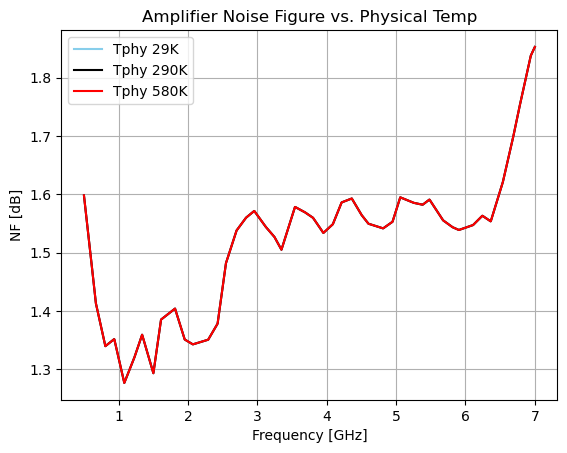

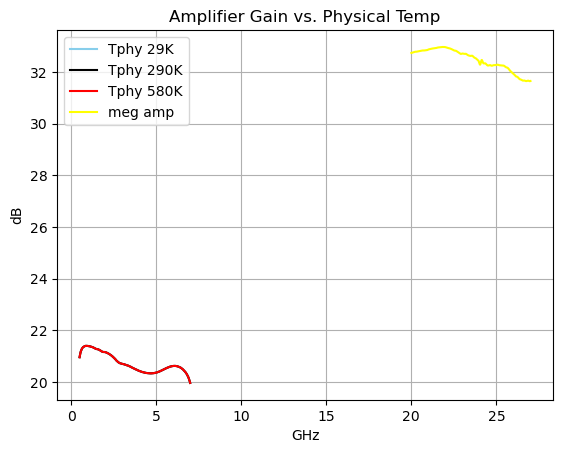

In [31]:
plt.figure()
plt.plot(freq1.f/1e9,10*np.log10(return_nf(2,amplifier_29k)),color='skyblue', label='Tphy 29K')
plt.plot(freq1.f/1e9,10*np.log10(return_nf(2,amplifier_290k)),color='k', label='Tphy 290K')
plt.plot(freq1.f/1e9,10*np.log10(return_nf(2,amplifier_580k)),color='r', label='Tphy 580K')
plt.legend()
plt.grid()
plt.title('Amplifier Noise Figure vs. Physical Temp')
plt.xlabel('Frequency [GHz]')
plt.ylabel('NF [dB]')


plt.figure()
plt.plot(amplifier_29k.f/1e9,20*np.log10(np.abs(amplifier_29k.s[:,1,0])),color='skyblue',label='Tphy 29K')
plt.plot(amplifier_290k.f/1e9,20*np.log10(np.abs(amplifier_290k.s[:,1,0])),color='k',label='Tphy 290K')
plt.plot(amplifier_580k.f/1e9,20*np.log10(np.abs(amplifier_580k.s[:,1,0])),color='r',label='Tphy 580K')
plt.plot(amp_meg.f/1e9,20*np.log10(np.abs(amp_meg.s[:,1,0])),color='yellow',label='meg amp')

plt.ylabel('dB')
plt.xlabel('GHz')
plt.legend(loc='best')
plt.title('Amplifier Gain vs. Physical Temp')
plt.grid()
plt.ylim()

In [32]:

attns=[attn_29k,attn_290k,attn_580k]
attns_name=['29k','290k','580k']
for n in range(len(attns)):
    
    '''
    Case 2, Cascading Attenuator with Amplifiers for Noise Figure Calculations
    '''
    Attn_to_29kAmp=rf.noisyNetwork.cascade_2port(attns[n],amplifier_29k,True)
    
    Attn_to_290kAmp=rf.noisyNetwork.cascade_2port(attns[n],amplifier_290k,True)
    
    Attn_to_580kAmp=rf.noisyNetwork.cascade_2port(attns[n],amplifier_580k,True)

    Attn_to_megAmp=rf.noisyNetwork.cascade_2port(attns[n],amp_meg,True)

    
    plt.figure(figsize=(7,4))
    # plt.plot(freq.f/1e9,10*np.log10(return_nf(2,Attn_to_29kAmp)),color='skyblue', label='Amp Tphy 29K')
    # plt.plot(freq.f/1e9,10*np.log10(return_nf(2,Attn_to_290kAmp)),color='k', label='Amp Tphy 290K')
    # plt.plot(freq.f/1e9,10*np.log10(return_nf(2,Attn_to_580kAmp)),color='r', label='Amp Tphy 580K')
    plt.plot(freq_meg.f/1e9,10*np.log10(return_nf(2,Attn_to_megAmp)),color='r', label='meg amp')
    plt.legend()
    plt.grid()
    plt.title('20dB '+attns_name[n]+' Attenuator Cascaded with Amplifier\n vs. Physical Temp (Noise Figure)')
    plt.xlabel('Frequency [GHz]')
    plt.ylabel('NF [dB]')
    
    
    plt.figure(figsize=(7,4))
    # plt.plot(Attn_to_29kAmp.f/1e9,20*np.log10(np.abs(Attn_to_29kAmp.s[:,1,0])),color='skyblue',label='Tphy 29K')
    # plt.plot(Attn_to_290kAmp.f/1e9,20*np.log10(np.abs(Attn_to_290kAmp.s[:,1,0])),color='k',label='Tphy 290K')
    # plt.plot(Attn_to_580kAmp.f/1e9,20*np.log10(np.abs(Attn_to_580kAmp.s[:,1,0])),color='r',label='Tphy 580K')
    plt.plot(Attn_to_megAmp.f/1e9,20*np.log10(np.abs(Attn_to_megAmp.s[:,1,0])),color='r',label='Tphy 580K')
    
    plt.ylabel('dB')
    plt.xlabel('GHz')
    plt.legend(loc='best')
    plt.title('20dB '+attns_name[n]+'  Attenuator Cascaded with Amplifier\n vs. Physical Temp (Gain)')
    plt.grid()
    plt.ylim()

ValueError: both networks must have same frequency data